# Final Project - Yelp Location Classification
#### CSCI 3832 Natural Language Processing

This should run top to bottom correctly. I have it set to run the entire dataset but if your system is not robust it may have trouble, in which case you can experiment with 'reviews_by_state_trimmed' dataframe which contains about 344,000 reviews. If this is still too much, run cell 7 again to trim even further.

In [142]:
# Necessary Imports

import os, random, sys, copy
import torch, torch.nn as nn, numpy as np
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer, pipeline
from datasets import load_dataset
# from evaluate import load
from tqdm.notebook import tqdm

In [ ]:
reviews_by_state = pd.read_csv(
    "C:/Users/danie/Downloads/reviews_with_locations.csv.gz",   # Adjust the path as necessary
    compression='gzip',
    usecols=["text", "state"]
)

# Preview the data
reviews_by_state.head()

,text,state
0,"If you decide to eat here, just be aware it is...",PA
1,This is the second time we tried turning point...,PA
2,The place is cute and the staff was very frien...,PA
3,We came on a Saturday morning after waiting a ...,PA
4,"Mediocre at best. The decor is very nice, and ...",PA


In [3]:
reviews_by_state['state'].value_counts()

state
PA    1598960
FL    1161545
LA     761673
TN     614388
MO     502385
IN     489752
AZ     431708
NV     430678
CA     348856
NJ     260897
ID     157572
DE      70302
IL      51832
Name: count, dtype: int64

In [4]:
reviews_by_state['state'].unique()

array(['PA', 'AZ', 'LA', 'CA', 'FL', 'IN', 'MO', 'TN', 'NV', 'NJ', 'IL',
       'ID', 'DE'], dtype=object)

In [5]:
glove_file = 'glove.6B/glove.6B.50d.txt' # modify to appropriate path for your file system

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        line = line.strip().split(' ')
        word = line[0]
        embed = np.asarray(line[1:], "float")

        embeddings_dict[word] = embed


print('Loaded {} words from glove'.format(len(embeddings_dict)))

low = -1.0 / 3
high = 1.0 / 3
embedding_matrix = np.random.uniform(low=low, high=high, size=(len(embeddings_dict)+1, 50))

word2id = {}
for i, word in enumerate(embeddings_dict.keys(), 1):

    word2id[word] = i                                
    embedding_matrix[i] = embeddings_dict[word]      

word2id['<pad>'] = 0

# Add <unk> token
word2id['unk'] = len(word2id)
embedding_matrix = np.vstack([
    embedding_matrix,
    np.random.uniform(low=low, high=high, size=(50,))
])

Loaded 400000 words from glove


In [ ]:
class YelpReviewByStateDataset(Dataset):
    def __init__(self, csv_path=None, df=None, word2id=None, max_length=256, data_limit=None, label_set=None, tokenizer=True):
        """
        :param csv_path: Path to CSV file with 'text' and 'state' columns (optional if df is provided)
        :param df: Optional preloaded DataFrame
        :param word2id: Dictionary mapping words to GloVe indices
        :param max_length: Max sequence length
        :param data_limit: Optionally limit number of rows
        :param label_set: Optional pre-defined label_set to enforce consistent label IDs across splits
        """
        self.word2id = word2id
        self.max_length = max_length

        # Load data
        if df is not None:
            self.df = df.copy()
        else:
            self.df = pd.read_csv(csv_path, compression='gzip', usecols=['text', 'state'])

        # Apply data limit regardless of source
        if data_limit:
            self.df = self.df.sample(n=data_limit, random_state=42).reset_index(drop=True)


        # Define label mappings
        if label_set is None:
            self.label_set = sorted(df['state'].unique())
        else:
            self.label_set = label_set

        self.label2id = {label: idx for idx, label in enumerate(self.label_set)}
        self.id2label = {idx: label for label, idx in self.label2id.items()}

        # Process data
        self.data = self.tokenize(df['text'].tolist(), df['state'].tolist(), tokenizer)
    
    def tokenize(self, texts, labels, tokenizer):
        examples = []
        for text, label in tqdm(zip(texts, labels), total=len(texts), desc="Tokenizing examples"):
            if tokenizer:
                tokens = word_tokenize(str(text).lower())  # Slow tokenizer using NLTK
            else:
                tokens = str(text).lower().split()  # Fast tokenizer
            ids = [self.word2id.get(tok, self.word2id.get('unk', 0)) for tok in tokens]

            # Truncate if too long
            if len(ids) > self.max_length:
                ids = ids[:self.max_length]

            length = len(ids)  # After truncation

            # Pad if too short
            if len(ids) < self.max_length:
                ids += [self.word2id.get('<pad>', 0)] * (self.max_length - len(ids))

            examples.append(((torch.tensor(ids), length), self.label2id[label]))
        
        return examples

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)



In [7]:
reviews_by_state_trimmed = reviews_by_state.groupby('state', group_keys=False).sample(frac=0.05, random_state=42).reset_index(drop=True)

In [8]:
reviews_by_state_trimmed.count()

text     344028
state    344028
dtype: int64

In [9]:
reviews_by_state_trimmed['state'].value_counts()

state
PA    79948
FL    58077
LA    38084
TN    30719
MO    25119
IN    24488
AZ    21585
NV    21534
CA    17443
NJ    13045
ID     7879
DE     3515
IL     2592
Name: count, dtype: int64

In [ ]:
# Load and split the data
# Take 5% from each state
# reviews_by_state = pd.read_csv("C:/Users/danie/Downloads/reviews_with_locations.csv.gz", compression='gzip', usecols=['text', 'state'])
train_df, valid_df = train_test_split(reviews_by_state_trimmed, test_size=0.2, random_state=42, stratify=reviews_by_state_trimmed['state'])

# Get label set from training only to ensure consistent mapping
label_set = sorted(train_df['state'].unique())

# Create datasets
train_dataset = YelpReviewByStateDataset(
    df=train_df,
    word2id=word2id,
    label_set=label_set,
    data_limit=10000,  # Limit training to 10k
    tokenizer=False
)

valid_dataset = YelpReviewByStateDataset(
    df=valid_df,
    word2id=word2id,
    label_set=label_set,
    data_limit=2000,    # Limit validation to 2k
    tokenizer=False
)

print(len(train_dataset), "train samples")
print(len(valid_dataset), "validation samples")
print(train_dataset[0])  # (tensor, label_id)


Tokenizing examples:   0%|          | 0/275222 [00:00<?, ?it/s]

Tokenizing examples:   0%|          | 0/68806 [00:00<?, ?it/s]

275222 train samples
68806 validation samples
((tensor([  101,    62,    42,   461,   193,  3641,     5,   243,     5,  5351,
        17112,     3,     5,   254,   193,   214,    11,  2180,    42, 79839,
           21,   101,    42,    95,   892,    50,   193,  3252,    26,   162,
           14,  2225,  1022,     6,   327,   138,    14,  2225,  1095,     3,
           42,   121,   497,   420,    13,    40,  4702,   193,  1249,     6,
          484,    21,     5,    49,    42,   856,    71,    89,     6,    40,
          120,    71,    34,  1097,   780,    13,    42,    87,   191,     3,
           42,  2530,     1,   247,    42,   120,    11,     8,  1248,     3,
           40,  1370,    71, 16902,   193,  3641,    11,     1,  1249,    67,
            5,     6,   138,    26,   806,   806,   446,     5,    65,     4,
           38,    42,   115,   856,    71,   243,   254,   193,   214,    11,
         2180,     6,    41,     5,  7647,    65,   560,   806,   806,   806,
          806,  

We'll also initialize our movie review dataset again, but with another slight change: while we're still padding the examples to the maximum length we describe, we need to keep track of the original length. This will help us save on some computations down the line. 

Now we'll load a train and validation dataset. 

Initialize the prediction function and training loop as before

In [11]:
def predict(model, valid_dataloader, device='cpu'):
    model.eval()
    total_correct = 0
    total_examples = len(valid_dataloader.dataset)

    with torch.no_grad():
        for (x, x_lengths), y in valid_dataloader:
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)               # shape: (batch_size, num_classes)
            predictions = torch.argmax(logits, dim=1)  # shape: (batch_size,)

            total_correct += (predictions == y).sum().item()

    accuracy = total_correct / total_examples
    print('accuracy: {:.2f}%'.format(accuracy * 100))
    return accuracy


In [12]:
def train_lstm_classification(model, train_dataset, valid_dataset, epochs=10, batch_size=32, learning_rate=.001, print_frequency=25):

    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


    epochs = epochs
    batch_size = batch_size
    print_frequency = print_frequency

    #We'll create an instance of a torch dataloader to collate our data. This class handles batching and shuffling (should be done each epoch)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)

    print('Total train batches: {}'.format(train_dataset.__len__() / batch_size))

    best_accuracy = 0.0
    best_model_sd = None

    for i in range(epochs):
        print('### Epoch: ' + str(i+1) + ' ###')
    
        model.train()

        avg_loss = 0

        for step, data in enumerate(train_dataloader):

            (x, x_lengths), y = data	# Our dataset is returning the input example x and also the lengths of the examples, so we'll unpack that here

            optimizer.zero_grad()

            model_output = model(x, x_lengths)

            loss = criteria(model_output, y)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

            if step % print_frequency == (print_frequency - 1):
                print('epoch: {} batch: {} loss: {}'.format(
                    i,
                    step,
                    avg_loss / print_frequency
                ))
                avg_loss = 0

        print('Evaluating...')
        model.eval()
        with torch.no_grad():
            acc = predict(model, valid_dataloader)
            if acc > best_accuracy:
                best_model_sd = copy.deepcopy(model.state_dict())
                best_accuracy = acc

    return model.state_dict(), best_model_sd

In [13]:
class LSTMModel(nn.Module):

    def __init__(self, embedding_matrix, num_classes, lstm_hidden_size=50, num_lstm_layers=1, bidirectional=True):

        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.lstm = nn.LSTM(input_size = embedding_matrix.shape[1],
                            hidden_size = lstm_hidden_size,
                            num_layers = num_lstm_layers,
                            bidirectional = bidirectional,
                            batch_first = True)
        
        self.hidden_1 = nn.Linear(lstm_hidden_size * 2, lstm_hidden_size)
        self.hidden_2 = nn.Linear(lstm_hidden_size, num_classes)
        self.num_directions = 2 if bidirectional else 1
        self.relu = nn.ReLU()

    def forward(self, input_batch, input_lengths):
        
        embedded_input = self.embedding(input_batch)
        
        packed_input = pack_padded_sequence(embedded_input, input_lengths, batch_first=True, enforce_sorted=False)

        packed_output, (hn, cn) = self.lstm(packed_input)                                                                       

        hn_view = hn.view(self.lstm.num_layers, self.num_directions, input_batch.shape[0], self.lstm.hidden_size)               # Reshape hn for clarity -- first dimension now represents each layer (total set by num_lstm_layers)

        hn_view_last_layer = hn_view[-1]                                                                                        # Taking the last layer for our final LSTM output

        hn_cat = torch.cat([hn_view_last_layer[-2, :, :], hn_view_last_layer[-1, :, :]], dim=1)                                 # Each layer has two directions. We want to use both of these vectors, so concatenate them

        hid = self.relu(self.hidden_1(hn_cat))

        output = self.hidden_2(hid)

        # raise KeyError
        #         
        return output

In [15]:
# model = LSTMModel(embedding_matrix, num_classes=len(train_dataset.label_set))
# model, best_model = train_lstm_classification(model, train_dataset, valid_dataset, batch_size=128, epochs=1)

In [16]:
def train_lstm_classification(model, train_dataset, valid_dataset, epochs=10, batch_size=32, learning_rate=0.001, print_frequency=25, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to the correct device
    model = model.to(device)

    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)

    print('Total train batches: {}'.format(len(train_dataset) / batch_size))

    best_accuracy = 0.0
    best_model_sd = None
    all_losses = []

    for epoch in range(epochs):
        print(f'### Epoch: {epoch + 1} ###')
        model.train()
        avg_loss = 0

        for step, ((x, x_lengths), y) in enumerate(train_dataloader):
            # Move tensors to GPU
            x = x.to(device)
            x_lengths = x_lengths.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            output = model(x, x_lengths)  # output shape: (batch_size, num_classes)

            loss = criteria(output, y)
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

            if step % print_frequency == (print_frequency - 1):
                avg_loss_value = avg_loss / print_frequency
                print(f'epoch: {epoch} batch: {step} loss: {avg_loss / print_frequency:.4f}')
                all_losses.append(avg_loss_value)
                avg_loss = 0

        print('Evaluating...')
        acc = predict(model, valid_dataloader, device=device)
        if acc > best_accuracy:
            best_model_sd = copy.deepcopy(model.state_dict())
            best_accuracy = acc

    return model.state_dict(), best_model_sd, all_losses


In [17]:
def predict(model, valid_dataloader, device='cpu'):
    model.eval()
    total_correct = 0
    total_examples = len(valid_dataloader.dataset)

    with torch.no_grad():
        for (x, x_lengths), y in valid_dataloader:
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)
            logits = model(x, x_lengths)
            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == y).sum().item()

    accuracy = total_correct / total_examples
    print('accuracy: {:.2f}%'.format(accuracy * 100))
    return accuracy


In [18]:
class LSTMModel(nn.Module):

    def __init__(self, embedding_matrix, num_classes, lstm_hidden_size=50, num_lstm_layers=1, bidirectional=True):

        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.lstm = nn.LSTM(input_size = embedding_matrix.shape[1],
                            hidden_size = lstm_hidden_size,
                            num_layers = num_lstm_layers,
                            bidirectional = bidirectional,
                            batch_first = True)
        
        self.hidden_1 = nn.Linear(lstm_hidden_size * 2, lstm_hidden_size)
        self.hidden_2 = nn.Linear(lstm_hidden_size, num_classes)
        self.num_directions = 2 if bidirectional else 1
        self.relu = nn.ReLU()

    def forward(self, input_batch, input_lengths):
        
        embedded_input = self.embedding(input_batch)
        
        packed_input = pack_padded_sequence(embedded_input, input_lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hn, cn) = self.lstm(packed_input)                                                                       

        hn_view = hn.view(self.lstm.num_layers, self.num_directions, input_batch.shape[0], self.lstm.hidden_size)               # Reshape hn for clarity -- first dimension now represents each layer (total set by num_lstm_layers)

        hn_view_last_layer = hn_view[-1]                                                                                        # Taking the last layer for our final LSTM output

        hn_cat = torch.cat([hn_view_last_layer[-2, :, :], hn_view_last_layer[-1, :, :]], dim=1)                                 # Each layer has two directions. We want to use both of these vectors, so concatenate them

        hid = self.relu(self.hidden_1(hn_cat))

        output = self.hidden_2(hid)

        # raise KeyError
        #         
        return output

In [ ]:
train_df, valid_df = train_test_split(reviews_by_state_trimmed, test_size=0.2, random_state=42, stratify=reviews_by_state_trimmed['state'])

# Get label set from training only to ensure consistent mapping
label_set = sorted(train_df['state'].unique())

# Create datasets
train_dataset = YelpReviewByStateDataset(
    df=train_df,
    word2id=word2id,
    label_set=label_set,
    data_limit=10000,
    tokenizer=False
)

valid_dataset = YelpReviewByStateDataset(
    df=valid_df,
    word2id=word2id,
    label_set=label_set,
    data_limit=2000,
    tokenizer=False
)

print(len(train_dataset), "train samples")
print(len(valid_dataset), "validation samples")
print(train_dataset[0])

Tokenizing examples:   0%|          | 0/275222 [00:00<?, ?it/s]

Tokenizing examples:   0%|          | 0/68806 [00:00<?, ?it/s]

275222 train samples
68806 validation samples
((tensor([   101,     62,     42,    461,    193,   3641,      5,    243,      5,
          5351, 400001,      5,    254,    193,    214,     11,   2180,     42,
         79839,     21,    101,     42,     95,    892,     50,    193,   3252,
            26,    162,     14,   2225,   1022,      6,    327,    138,     14,
          2225,   1095,      3,     42,    121,    497,    420,     13,     40,
          4702,    193,   1249,      6,    484,     21,      5,     49,     42,
        400001,     89,      6,     40, 400001,     34,   1097,    780,     13,
            42,     87, 400001,     42,   2530,      1,    247,     42,    120,
            11,      8, 400001,     40, 400001,  16902,    193,   3641,     11,
             1,   1249,     67,      5,      6,    138, 400001,    446,      5,
            65,      4,     38,     42,    115, 400001,    243,    254,    193,
           214,     11,   2180,      6,     41,      5,   7647,     65, 

Using device: cuda
Total train batches: 2150.171875
### Epoch: 1 ###
epoch: 0 batch: 24 loss: 2.4325
epoch: 0 batch: 49 loss: 2.2688
epoch: 0 batch: 74 loss: 2.2794
epoch: 0 batch: 99 loss: 2.2773
epoch: 0 batch: 124 loss: 2.2743
epoch: 0 batch: 149 loss: 2.2694
epoch: 0 batch: 174 loss: 2.2897
epoch: 0 batch: 199 loss: 2.2798
epoch: 0 batch: 224 loss: 2.2849
epoch: 0 batch: 249 loss: 2.2788
epoch: 0 batch: 274 loss: 2.2704
epoch: 0 batch: 299 loss: 2.2683
epoch: 0 batch: 324 loss: 2.2582
epoch: 0 batch: 349 loss: 2.2461
epoch: 0 batch: 374 loss: 2.2858
epoch: 0 batch: 399 loss: 2.2875
epoch: 0 batch: 424 loss: 2.2942
epoch: 0 batch: 449 loss: 2.2589
epoch: 0 batch: 474 loss: 2.2658
epoch: 0 batch: 499 loss: 2.2857
epoch: 0 batch: 524 loss: 2.2632
epoch: 0 batch: 549 loss: 2.2694
epoch: 0 batch: 574 loss: 2.2807
epoch: 0 batch: 599 loss: 2.2670
epoch: 0 batch: 624 loss: 2.2703
epoch: 0 batch: 649 loss: 2.2709
epoch: 0 batch: 674 loss: 2.2761
epoch: 0 batch: 699 loss: 2.2910
epoch: 0 ba

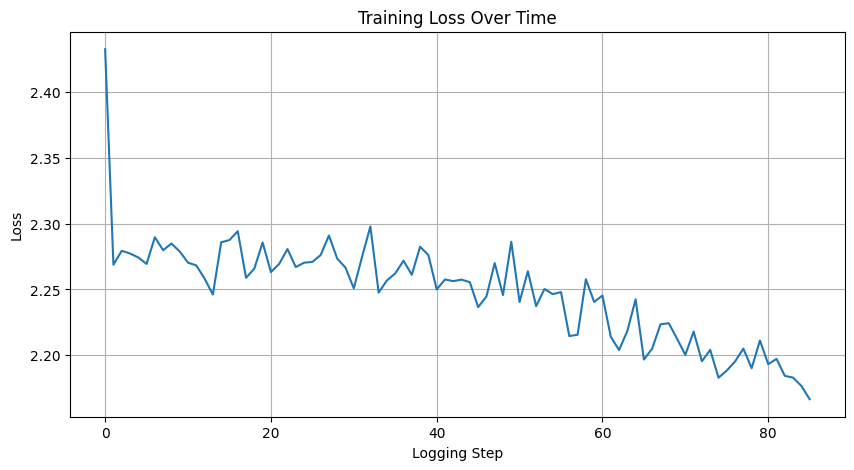

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(embedding_matrix, num_classes=len(train_dataset.label_set))
model_sd, best_model_sd, losses = train_lstm_classification(
    model, train_dataset, valid_dataset, batch_size=128, epochs=1, device=device
)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (x, x_lengths), y in torch.utils.data.DataLoader(dataset, batch_size=128):
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=dataset.label_set)
    print(report)
    return report

# Evaluate the model on the validation dataset
report = evaluate_model(model, valid_dataset, device=device)

              precision    recall  f1-score   support

          AZ       0.00      0.00      0.00      4317
          CA       0.65      0.06      0.11      3488
          DE       0.00      0.00      0.00       703
          FL       0.28      0.18      0.22     11615
          ID       0.00      0.00      0.00      1576
          IL       0.00      0.00      0.00       518
          IN       0.00      0.00      0.00      4898
          LA       0.55      0.28      0.37      7617
          MO       0.47      0.04      0.07      5024
          NJ       0.00      0.00      0.00      2609
          NV       0.00      0.00      0.00      4307
          PA       0.26      0.92      0.40     15990
          TN       0.00      0.00      0.00      6144

    accuracy                           0.28     68806
   macro avg       0.17      0.11      0.09     68806
weighted avg       0.24      0.28      0.18     68806



C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

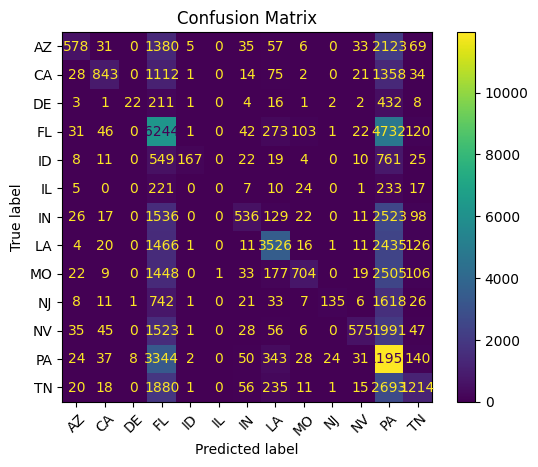

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (x, x_lengths), y in torch.utils.data.DataLoader(dataset, batch_size=128):
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(dataset.label_set)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.label_set)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix for the validation dataset
plot_confusion_matrix(model, valid_dataset, device=device)

In [28]:
train_tokenized_df, valid_tokenized_df = train_test_split(reviews_by_state, test_size=0.2, random_state=42, stratify=reviews_by_state['state'])

# Get label set from training only to ensure consistent mapping
label_set = sorted(train_tokenized_df['state'].unique())

# Create datasets
train_tokenized_dataset = YelpReviewByStateDataset(
    df=train_tokenized_df,
    word2id=word2id,
    label_set=label_set,
    tokenizer=False
)

valid_tokenized_dataset = YelpReviewByStateDataset(
    df=valid_tokenized_df,
    word2id=word2id,
    label_set=label_set,
    tokenizer=False
)

print(len(train_tokenized_dataset), "train samples")
print(len(valid_tokenized_dataset), "validation samples")
print(train_tokenized_dataset[0])  # (tensor, label_id)

Tokenizing examples:   0%|          | 0/5504438 [00:00<?, ?it/s]

Tokenizing examples:   0%|          | 0/1376110 [00:00<?, ?it/s]

5504438 train samples
1376110 validation samples
((tensor([   354, 400001,   3224,   2697,   2070,      6,    497,   4346, 400001,
            54,     41,     78,   3083,   2761,     22,      1,   2848,     12,
         18789,  16031,    193, 400001,    552,     18,  12210,  14035,     16,
            16,   3007,      6, 400001,   4232,      4,  12210,      6,    192,
        400001,     53,   1299,  21519,  12210,  39811,     12,   3083,   1276,
            11,    654, 400001,     42,     41,   7412,   9108,   7015,     18,
          1904,  54692,      6, 400001,   1175,   9108,    192,  14982,      6,
           937,     16, 400001,   3083, 400001,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(embedding_matrix, num_classes=len(train_tokenized_dataset.label_set))
model_sd, best_model_sd, losses = train_lstm_classification(
    model, train_tokenized_dataset, valid_tokenized_dataset, batch_size=128, epochs=1, device=device
)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

AttributeError: 'BertLSTMDataset' object has no attribute 'label_set'

In [30]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (x, x_lengths), y in torch.utils.data.DataLoader(dataset, batch_size=128):
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=dataset.label_set)
    print(report)
    return report

# Evaluate the model on the validation dataset
report = evaluate_model(model, valid_dataset, device=device)

              precision    recall  f1-score   support

          AZ       0.73      0.13      0.23      4317
          CA       0.77      0.24      0.37      3488
          DE       0.71      0.03      0.06       703
          FL       0.29      0.54      0.38     11615
          ID       0.92      0.11      0.19      1576
          IL       0.00      0.00      0.00       518
          IN       0.62      0.11      0.19      4898
          LA       0.71      0.46      0.56      7617
          MO       0.75      0.14      0.24      5024
          NJ       0.82      0.05      0.10      2609
          NV       0.76      0.13      0.23      4307
          PA       0.34      0.75      0.47     15990
          TN       0.60      0.20      0.30      6144

    accuracy                           0.39     68806
   macro avg       0.62      0.22      0.25     68806
weighted avg       0.55      0.39      0.35     68806



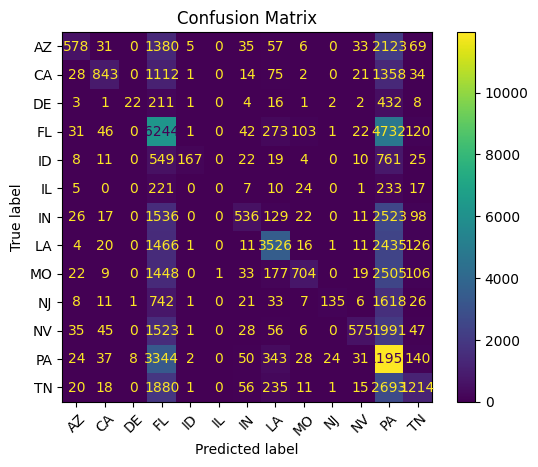

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (x, x_lengths), y in torch.utils.data.DataLoader(dataset, batch_size=128):
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(dataset.label_set)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.label_set)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix for the validation dataset
plot_confusion_matrix(model, valid_dataset, device=device)

In [128]:
model.eval()

LSTMModelWithBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Extract mislabeled examples for CA
mislabeled_ca = []

model.eval()
with torch.no_grad():
    for (x, x_lengths), y in torch.utils.data.DataLoader(valid_dataset, batch_size=128):
        x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)
        logits = model(x, x_lengths)
        preds = torch.argmax(logits, dim=1)

        for i, (true_label, pred_label) in enumerate(zip(y.cpu().tolist(), preds.cpu().tolist())):
            if true_label != pred_label and valid_dataset.id2label[true_label] == "CA":
                mislabeled_ca.append((valid_dataset.df.iloc[i]["text"], 
                                      valid_dataset.id2label[true_label], 
                                      valid_dataset.id2label[pred_label]))

# Display 25 mislabeled examples
for text, true_label, pred_label in mislabeled_ca[:25]:
    print(f"Text: {text}\nTrue Label: {true_label}, Predicted Label: {pred_label}\n")

TypeError: LSTMModelWithBERT.forward() missing 1 required positional argument: 'input_lengths'

In [126]:
def count_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"The model has {total_params} parameters.")

count_model_parameters(model)

The model has 109815341 parameters.


   State  Count  Percentage
0     PA  15990   23.239252
2     FL  11615   16.880795
6     LA   7617   11.070256
4     TN   6144    8.929454
3     MO   5024    7.301689
8     IN   4898    7.118565
1     AZ   4317    6.274162
7     NV   4307    6.259629
5     CA   3488    5.069325
9     NJ   2609    3.791820
10    ID   1576    2.290498
11    DE    703    1.021713
12    IL    518    0.752841


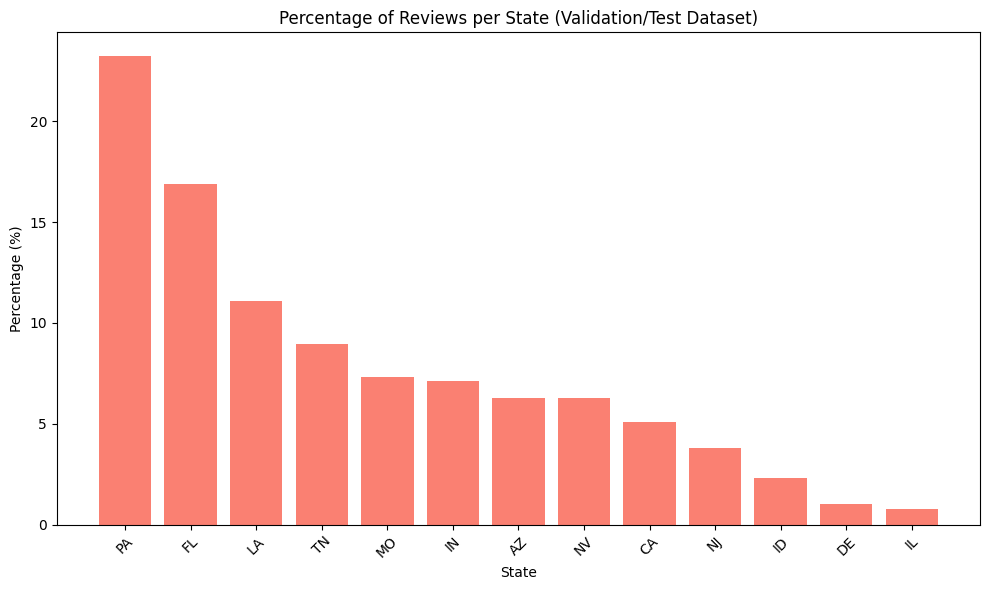

In [36]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Extract label IDs from the validation set
label_ids = [label for (_, label) in valid_dataset.data]

# Step 2: Count how many times each label appears
label_counts = Counter(label_ids)

# Step 3: Map label IDs back to state names
label_names = [valid_dataset.id2label[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# Step 4: Create a DataFrame
df = pd.DataFrame({
    'State': label_names,
    'Count': counts
})
df['Percentage'] = 100 * df['Count'] / df['Count'].sum()
df = df.sort_values(by='Percentage', ascending=False)

# Step 5: Print it
print(df)

# Step 6: Plot it
plt.figure(figsize=(10, 6))
plt.bar(df['State'], df['Percentage'], color='salmon')
plt.title('Percentage of Reviews per State (Validation/Test Dataset)')
plt.xlabel('State')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import torch
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def plot_correct_predictions_by_state(model, dataset, device):
    model.eval()
    correct_counts = Counter()
    total_counts = Counter()

    with torch.no_grad():
        for (x, x_lengths), y in torch.utils.data.DataLoader(dataset, batch_size=128):
            x, x_lengths, y = x.to(device), x_lengths.to(device), y.to(device)

            logits = model(x, x_lengths)
            preds = torch.argmax(logits, dim=1)

            for true_label, pred_label in zip(y.cpu().tolist(), preds.cpu().tolist()):
                state = dataset.id2label[true_label]
                total_counts[state] += 1
                if true_label == pred_label:
                    correct_counts[state] += 1

    # Create a DataFrame
    df = pd.DataFrame({
        'State': list(total_counts.keys()),
        'Correct': [correct_counts[s] for s in total_counts.keys()],
        'Total': [total_counts[s] for s in total_counts.keys()],
    })
    df['Accuracy (%)'] = 100 * df['Correct'] / df['Total']
    df = df.sort_values(by='Accuracy (%)', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(df['State'], df['Correct'], color='green')
    plt.title('Correctly Labeled Reviews per State (Validation Set)')
    plt.xlabel('State')
    plt.ylabel('Correct Predictions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df


In [ ]:
df_accuracy = plot_correct_predictions_by_state(model, valid_dataset, device=device)

NameError: name 'plot_correct_predictions_by_state' is not defined

In [ ]:
valid_tokenized_dataset = valid_dataset

df_accuracy = plot_correct_predictions_by_state(model, valid_tokenized_dataset, device=device)

### Attempt at BERT below

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import Dataset
from tqdm import tqdm

class YelpReviewByStateBERTDataset(Dataset):
    def __init__(self, csv_path=None, df=None, tokenizer=None, max_length=256, data_limit=None, label_set=None):


        self.tokenizer = tokenizer or BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length

        # Load data
        if df is not None:
            self.df = df.copy()
        else:
            self.df = pd.read_csv(csv_path, compression='gzip', usecols=['text', 'state'])

        if data_limit:
            self.df = self.df.sample(n=data_limit, random_state=42).reset_index(drop=True)

        # Label setup
        if label_set is None:
            self.label_set = sorted(self.df['state'].unique())
        else:
            self.label_set = label_set

        self.label2id = {label: idx for idx, label in enumerate(self.label_set)}
        self.id2label = {idx: label for label, idx in self.label2id.items()}

        self.data = self.tokenize(self.df['text'].tolist(), self.df['state'].tolist())

    def tokenize(self, texts, labels, chunk_size=1024):
        examples = []
        for i in tqdm(range(0, len(texts), chunk_size), desc="Batch Tokenizing with BERT"):
            batch_texts = texts[i:i+chunk_size]
            batch_labels = labels[i:i+chunk_size]

            encoded = self.tokenizer(
                batch_texts,
                padding='max_length',
                truncation=True,
                max_length=self.max_length,
                return_tensors='pt'
            )

            examples.extend([
                {
                    'input_ids': encoded['input_ids'][j],
                    'attention_mask': encoded['attention_mask'][j],
                    'label': torch.tensor(self.label2id[batch_labels[j]], dtype=torch.long)
                }
                for j in range(len(batch_texts))
            ])
        return examples



    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)


In [146]:
from transformers import BertModel

class BERT_LSTM_Model(nn.Module):
    def __init__(self, num_classes, lstm_hidden_size=128, num_lstm_layers=1, bidirectional=True):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        
        # Freeze BERT to use as feature extractor
        for param in self.bert.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            bidirectional=bidirectional,
            batch_first=True
        )

        self.hidden_1 = nn.Linear(lstm_hidden_size * 2 if bidirectional else lstm_hidden_size, lstm_hidden_size)
        self.hidden_2 = nn.Linear(lstm_hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.num_directions = 2 if bidirectional else 1

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state  # (B, T, 768)

        # Feed to LSTM
        lstm_out, (hn, cn) = self.lstm(sequence_output)

        # hn: (num_layers * num_directions, B, H)
        # Take last layer's forward and backward hidden states
        hn_view = hn.view(self.lstm.num_layers, self.num_directions, input_ids.size(0), self.lstm.hidden_size)
        last_layer = hn_view[-1]
        if self.num_directions == 2:
            hn_cat = torch.cat((last_layer[0], last_layer[1]), dim=1)
        else:
            hn_cat = last_layer[0]

        hid = self.relu(self.hidden_1(hn_cat))
        out = self.hidden_2(hid)
        return out


In [148]:
def evaluate_lstm_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [154]:
def train_bert_lstm_classification(model, train_dataset, valid_dataset, epochs=10, batch_size=32, learning_rate=1e-4, print_frequency=25, device=None):
    import copy
    from torch.utils.data import DataLoader
    from tqdm import tqdm
    import torch.nn as nn
    import torch

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

    best_accuracy = 0.0
    best_model_sd = None
    all_losses = []

    for epoch in range(epochs):
        print(f'\n### Epoch {epoch + 1}/{epochs} ###')
        model.train()
        running_loss = 0.0

        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (step + 1) % print_frequency == 0:
                avg_loss = running_loss / print_frequency
                print(f"Epoch {epoch + 1}, Step {step + 1}, Loss: {avg_loss:.4f}")
                all_losses.append(avg_loss)
                running_loss = 0.0

        print("Evaluating...")
        acc = evaluate_lstm_model(model, valid_dataloader, device)
        print(f"Validation Accuracy: {acc:.2%}")

        if acc > best_accuracy:
            best_model_sd = copy.deepcopy(model.state_dict())
            best_accuracy = acc

    return model.state_dict(), best_model_sd, all_losses


In [149]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(reviews_by_state_trimmed, test_size=0.1, stratify=reviews_by_state_trimmed['state'], random_state=42)


In [150]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = YelpReviewByStateBERTDataset(df=train_df, tokenizer=tokenizer, max_length=128)
val_dataset = YelpReviewByStateBERTDataset(df=val_df, tokenizer=tokenizer, max_length=128, label_set=train_dataset.label_set)

Batch Tokenizing with BERT: 100%|██████████| 34/34 [01:03<00:00,  1.86s/it]


In [152]:
model = BERT_LSTM_Model(num_classes=len(train_dataset.label_set))


In [ ]:
import time
model.eval()
batch = next(iter(train_dataloader))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)

start = time.time()
with torch.no_grad():
    _ = model(input_ids, attention_mask)
print(f"Time for one forward pass: {time.time() - start:.2f}s")


In [ ]:
# state_dict, best_model_sd, loss_history = train_bert_lstm_classification(
#     model,
#     train_dataset=train_dataset,
#     valid_dataset=val_dataset,
#     epochs=3,
#     batch_size=32,
#     learning_rate=1e-4,
#     print_frequency=100
# )


Using device: cuda

### Epoch 1/3 ###


Training:   0%|          | 0/9676 [00:00<?, ?it/s]

In [ ]:
# Load best model weights before final evaluation
model.load_state_dict(best_model_sd)

# Final eval on validation set
final_acc = evaluate_lstm_model(model, torch.utils.data.DataLoader(val_dataset, batch_size=64), device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Final Validation Accuracy: {final_acc:.2%}")
